In [58]:
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az
from scipy.special import gammaln
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats     import gaussian_kde
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d

rng = np.random.default_rng(42)

## Profile Likelihood for Poisson Regression

For each fixed value of $\beta$ on grid, the log-likelihood for a single observation is

$$
\ell_i(\beta)
= \log p(y_i \mid x_i, \beta)
= y_i \,\bigl(\beta\,x_i\bigr)
- \exp\!\bigl(\beta\,x_i\bigr)
- \log\bigl(y_i!\bigr).
$$

Since $\beta$ is the only parameter, the **profile log-likelihood** is just the sum over all \(n\) observations:

$$
\ell(\beta)
= \sum_{i=1}^n \ell_i(\beta)
= \sum_{i=1}^n \Bigl[y_i(\beta\,x_i) \;-\; e^{\beta\,x_i} \;-\; \log(y_i!)\Bigr].
$$

In [22]:
def simulate_profile_likelihoods(
    K: int = 5,
    S: int = 8,
    O: int = 8,
    n_obs: int = 100,

    *,
    beta_mean: np.ndarray | None = None,
    beta_sds:  np.ndarray | None = None,
    true_pis: np.ndarray | None = None,
    grid: np.ndarray | None = None,
    seed: int = 0
):
    """
    Simulate profile-likelihood curves for a K-component Poisson-regression mixture
    where *each* component k generates its β from  N(beta_mean[k], beta_sds[k]²).

    Parameters
    ----------
    beta_mean, beta_sds : array-like length-K
        Component-specific means and standard deviations that define the mixture
        of normals for β.  If omitted they default to equally-spaced means in
        [-1,1] with sd = 0.15.

    Other parameters are unchanged from the original function.

    Returns
    -------
    df : pandas.DataFrame
        Long-format table with columns ['source','outcome','point','value'].
    true_pis : np.ndarray, shape (S, K)
        The source-specific mixture weights actually used to generate the data.
    """
    rng = np.random.default_rng(seed)

    # ------------------------------------------------------------------  β priors
    if beta_mean is None:
        beta_mean = np.linspace(-1, 1, K)
    if beta_sds is None:
        beta_sds = np.full(K, 0.15)
    beta_mean = np.asarray(beta_mean, dtype=float)
    beta_sds  = np.asarray(beta_sds,  dtype=float)
    if beta_mean.shape != (K,) or beta_sds.shape != (K,):
        raise ValueError("beta_mean and beta_sds must be length-K arrays")

    # ------------------------------------------------------------------  grid
    if grid is None:
        raise ValueError("Provide a 1-D array of grid points via the `grid` argument")
    grid = np.asarray(grid, dtype=float)

    # ------------------------------------------------------------------  Dirichlet weights for each source
    if true_pis is None:
        true_pis = true_pis = rng.dirichlet(np.ones(K) * 2.0, size=S)
             # shape (S, K)

    records = []
    for s in range(1, S + 1):
        pi_s = true_pis[s - 1]                                   # mixture weights
        for o in range(1, O + 1):
            # ----- 1) Assign every observation to a latent component z_i
            z = rng.choice(K, size=n_obs, p=pi_s)                # shape (n_obs,)

            # ----- 2) For each i draw β_i ~ N(β̄_{z_i}, σ_{z_i})
            beta_i = rng.normal(loc=beta_mean[z], scale=beta_sds[z])

            # ----- 3) Covariate x_i  and response  y_i | β_i
            x_i  = rng.uniform(-1, 1, size=n_obs)
            lam  = np.exp(beta_i * x_i)
            y_i  = rng.poisson(lam)

            # ----- 4) Profile log-likelihood on the supplied grid
            #         ℓ(b) = Σᵢ [ y_i (b x_i) − exp(b x_i) − log(y_i!) ]
            #         Note: gammaln(y+1) = log(y!)
            for b in grid:
                logp = y_i * (b * x_i) - np.exp(b * x_i) - gammaln(y_i + 1)
                records.append(
                    dict(source=s, outcome=o, point=b, value=logp.sum())
                )

    df = pd.DataFrame.from_records(records)
    return df, true_pis

grid_pts   = np.linspace(-10, 10, 100)
#mean draw from gaussian with mean 1 and sd 0.15
beta_mean = rng.normal(loc=2.0, scale=3.0, size=5)
beta_sds = np.abs(rng.normal(loc=0.0, scale=1.0, size=5))

df_sim, true_pis = simulate_profile_likelihoods(
    K=5, S=8, O=8, n_obs=100,
    beta_mean=beta_mean,
    beta_sds=beta_sds,
    grid=grid_pts,
    seed=42
)

df_sim.to_csv("simulated_profileLikelihoods.csv", index=False)


For each outcome $o=1,\dots,O$ and observation $i=1,\dots,n$:

\begin{aligned}
z_{s,o,i} &\sim \mathrm{Categorical}(\pi_s),\\
x_{s,o,i} &\sim \mathrm{Uniform}(-1,1),\\
y_{s,o,i} &= \beta_{\,z_{s,o,i}}\,x_{s,o,i} + \varepsilon_{s,o,i},\quad
\varepsilon_{s,o,i}\sim\mathcal{N}(0,\sigma^2).
\end{aligned}

At each candidate $b$ in the grid:
$$
\ell_{s,o}(b)
=
\sum_{i=1}^n \log \bigl[\mathcal{N}(y_{s,o,i}\mid b\,x_{s,o,i},\,\sigma^2)\bigr]
=
-\frac{n}{2}\log(2\pi\sigma^2)
\;-\;
\frac{1}{2\sigma^2}\sum_{i=1}^n\bigl(y_{s,o,i}-b\,x_{s,o,i}\bigr)^2.
$$

In [4]:
def simulate_profile_likelihoods_linreg(
    K: int = 5,
    S: int = 8,
    O: int = 8,
    n_obs: int = 100,
    *,
    beta_mean: np.ndarray | None = None,
    beta_sds:  np.ndarray | None = None,
    true_pis:  np.ndarray | None = None,
    grid: np.ndarray | None = None,
    sigma_noise: float = 1.0,
    seed: int = 0
):
    """
    Simulate profile-likelihood curves for a K-component *Gaussian–mixture*
    linear-regression model.

    For every source s = 1,…,S and outcome o = 1,…,O:

        1. Choose mixture weights  π_s  ~ Dirichlet  (if not supplied).
        2. For each observation i = 1,…,n_obs
               z_i       ~ Categorical(π_s)
               β_i       ~ Normal(beta_mean[z_i], beta_sds[z_i]**2)
               x_i       ~ Uniform(-1, 1)
               y_i       = β_i · x_i  +  ε_i ,     ε_i ~ Normal(0, σ_noise²)

    At every candidate slope b in the supplied `grid` we evaluate

        ℓ(b) = -½ · [ n_obs · log(2πσ²)  +  Σ_i (y_i − b·x_i)² / σ² ]

    Parameters
    ----------
    beta_mean, beta_sds : array-like length-K
        Means and standard deviations of the K Gaussian components that form
        the mixture prior for β.  Defaults are equally spaced means in [-1,1]
        with sd = 0.15.
    true_pis : array, shape (S, K), optional
        Source-specific mixture weights.  If omitted they are drawn from a
        symmetric Dirichlet(2.0).
    grid : 1-D array of candidate β values at which the profile likelihood is
        computed.  Must be provided.
    sigma_noise : float
        Observation-level noise standard deviation.
    seed : int
        Random-number-generator seed.

    Returns
    -------
    df : pandas.DataFrame
        Long-format table with columns ['source', 'outcome', 'point', 'value'].
    true_pis : np.ndarray, shape (S, K)
        Mixture weights actually used for each source.
    """
    rng = np.random.default_rng(seed)

    # -------------------------------------------------------  mixture parameters
    if beta_mean is None:
        beta_mean = np.linspace(-1, 1, K)
    if beta_sds is None:
        beta_sds = np.full(K, 0.15)
    beta_mean = np.asarray(beta_mean, dtype=float)
    beta_sds  = np.asarray(beta_sds,  dtype=float)
    if beta_mean.shape != (K,) or beta_sds.shape != (K,):
        raise ValueError("`beta_mean` and `beta_sds` must be length-K arrays")

    # -------------------------------------------------------  evaluation grid
    if grid is None:
        raise ValueError("Please supply a 1-D array of grid points via `grid`.")
    grid = np.asarray(grid, dtype=float)

    # -------------------------------------------------------  mixture weights
    if true_pis is None:
        true_pis = rng.dirichlet(np.full(K, 2.0), size=S)   # (S,K)

    # -------------------------------------------------------  simulate & score
    const_term = -0.5 * n_obs * np.log(2 * np.pi * sigma_noise**2)
    records = []

    for s in range(1, S + 1):
        pi_s = true_pis[s - 1]                     # mixture weights for source s
        for o in range(1, O + 1):
            # --- latent component & β draw for every observation
            z   = rng.choice(K, size=n_obs, p=pi_s)
            bet = rng.normal(loc=beta_mean[z], scale=beta_sds[z])
            # --- covariate & response
            x   = rng.uniform(-1, 1, size=n_obs)
            y   = bet * x + rng.normal(0, sigma_noise, size=n_obs)

            # --- profile log-likelihood evaluated on the grid
            for b in grid:
                resid_sq = (y - b * x) ** 2
                ll       = const_term - 0.5 * resid_sq.sum() / sigma_noise**2
                records.append(
                    dict(source=s, outcome=o, point=b, value=ll)
                )

    df = pd.DataFrame.from_records(records)
    return df, true_pis

grid_pts   = np.linspace(-10, 10, 100)
beta_mean  = rng.normal(loc=1.5, scale=0.7, size=5)
beta_sds = np.abs(rng.normal(loc=0.0, scale=1.0, size=5))

df_sim, pis = simulate_profile_likelihoods_linreg(
    K=5, S=8, O=8, n_obs=120,
    beta_mean=beta_mean,
    beta_sds=beta_sds,
    grid=grid_pts,
    sigma_noise=0.8,
    seed=2025
)


In [5]:
N_sources = 8
source_outcome_data = {}
for s in range(1, N_sources+1):
    df_s = df_sim[df_sim["source"]==s]
    outcome_list = []
    for o in sorted(df_s["outcome"].unique()):
        arr = df_s[df_s["outcome"]==o][["point","value"]].to_numpy()
        outcome_list.append(jnp.array(arr))
    source_outcome_data[s] = outcome_list

num_outcomes_dict = {s: len(source_outcome_data[s])
                     for s in range(2, N_sources+1)}

sample: 100%|██████████| 25000/25000 [01:36<00:00, 260.21it/s, 29 steps of size 5.69e-02. acc. prob=0.82] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha0      1.05      0.36      0.99      0.49      1.60   1963.10      1.00
      beta_1      2.01      0.06      2.00      1.91      2.10   3240.97      1.00
      beta_2      2.10      0.03      2.11      2.05      2.16   2923.90      1.00
      beta_3      1.95      0.04      1.94      1.90      2.01   3202.85      1.00
      beta_4      1.93      0.03      1.92      1.89      1.97   3468.25      1.00
      beta_5      1.97      0.05      1.96      1.90      2.06   3480.80      1.00
      beta_6      1.91      0.03      1.92      1.87      1.96   2987.91      1.00
      beta_7      2.13      0.03      2.12      2.08      2.18   3701.65      1.00
      beta_8      1.83      0.06      1.83      1.73      1.93   3398.59      1.00
beta_tilt[0]      0.58      0.12      0.58      0.39      0.78   1872.81      1.00
beta_tilt[1]      0.21      0.11      0.18      0.05      0.38   1755.17      1.00
bet

array([[<Axes: title={'center': 'alpha0'}>,
        <Axes: title={'center': 'alpha0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_3'}>,
        <Axes: title={'center': 'beta_3'}>],
       [<Axes: title={'center': 'beta_4'}>,
        <Axes: title={'center': 'beta_4'}>],
       [<Axes: title={'center': 'beta_5'}>,
        <Axes: title={'center': 'beta_5'}>],
       [<Axes: title={'center': 'beta_6'}>,
        <Axes: title={'center': 'beta_6'}>],
       [<Axes: title={'center': 'beta_7'}>,
        <Axes: title={'center': 'beta_7'}>],
       [<Axes: title={'center': 'beta_8'}>,
        <Axes: title={'center': 'beta_8'}>],
       [<Axes: title={'center': 'beta_tilt'}>,
        <Axes: title={'center': 'beta_tilt'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: ti

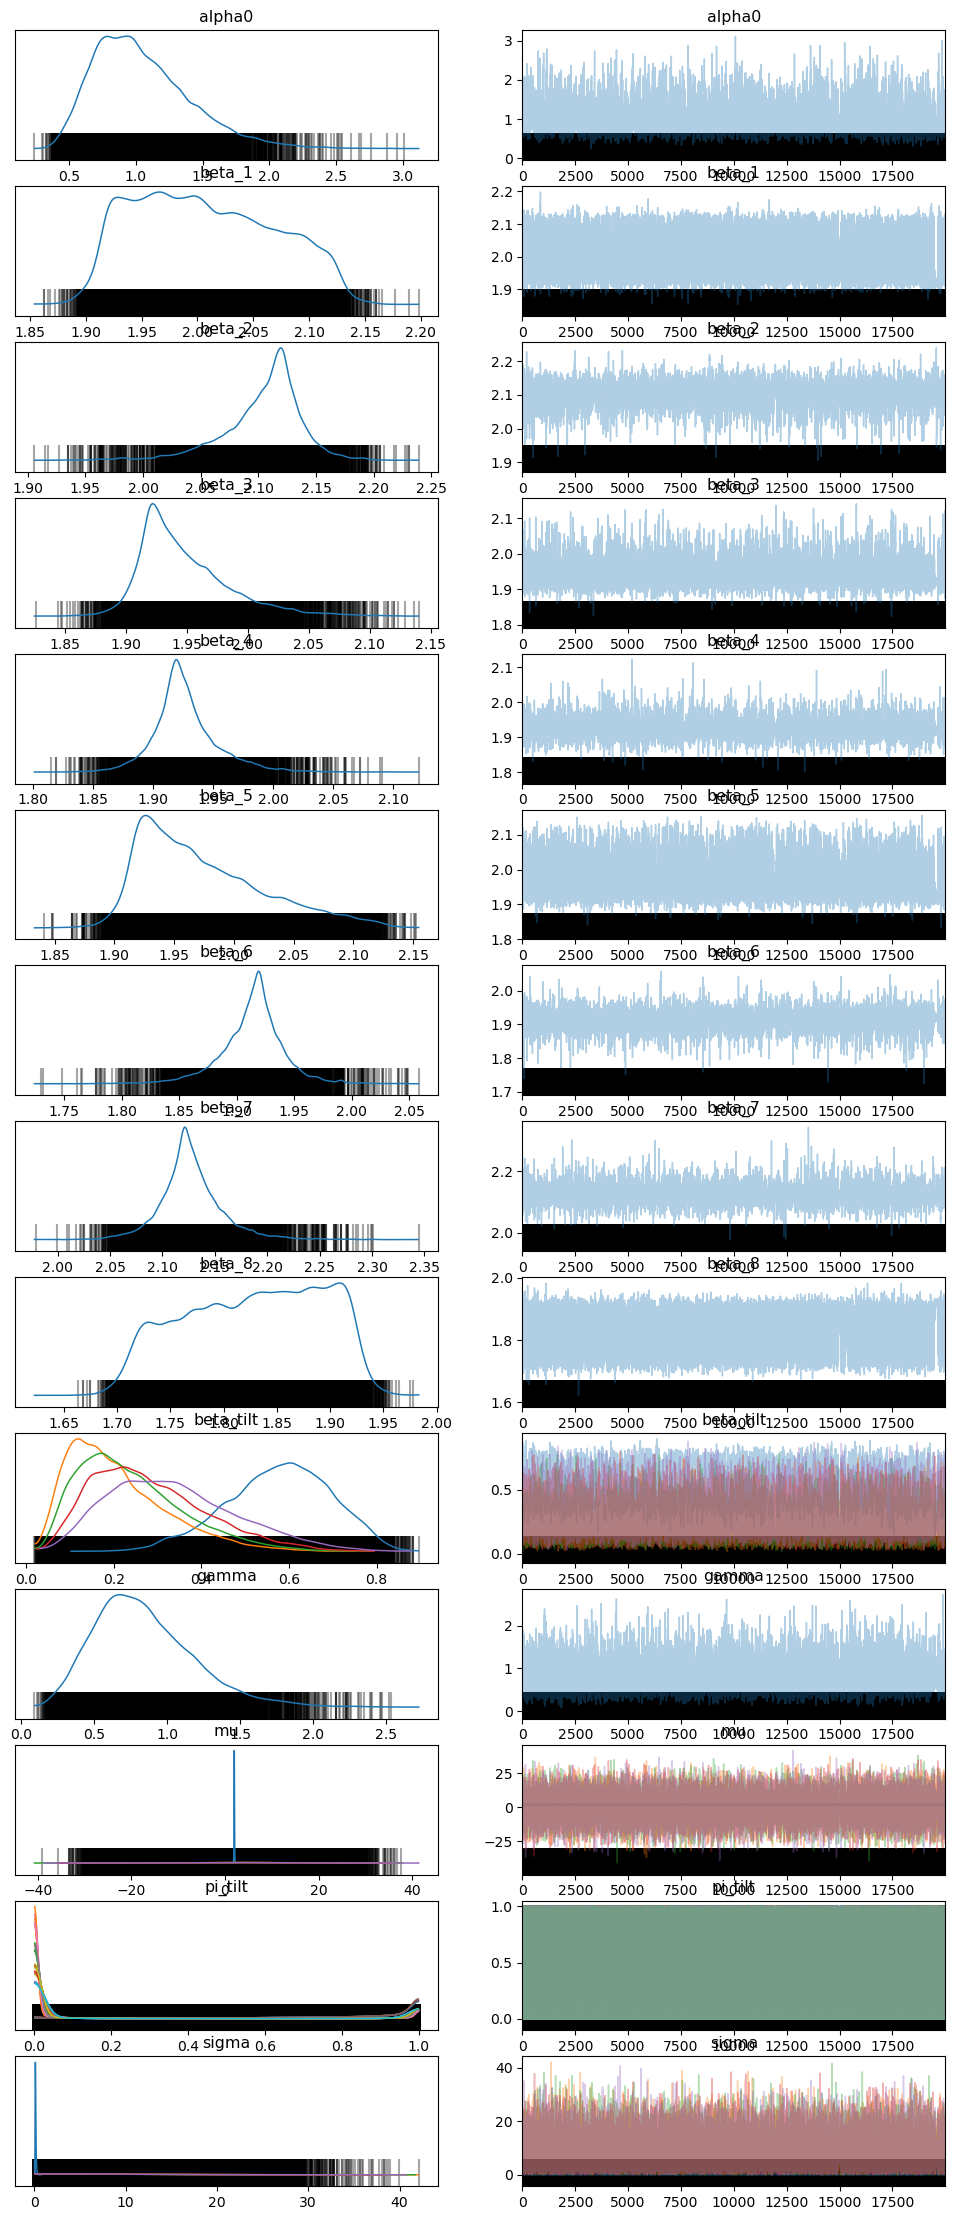

In [64]:
def stick_breaking(beta):
    rem = jnp.concatenate([jnp.array([1.]), jnp.cumprod(1-beta)[:-1]])
    return beta * rem

def reparameterize(pi):
    return pi / jnp.sum(pi)

def custom_loglike(beta, outcome_data_list):
    total_ll = 0.
    for outcome_data in outcome_data_list:
        x_vals = outcome_data[:,0]
        loglike_vals = outcome_data[:,1]
        total_ll += jnp.interp(beta, x_vals, loglike_vals)
    return total_ll

def HDP_model(source_outcome_data, num_outcomes_dict, N_sources, k, data_point_mean):
    gamma = numpyro.sample("gamma", dist.Gamma(1.0,5.0))
    alpha0 = numpyro.sample("alpha0", dist.Gamma(1.0,5.0))
    beta_tilt = numpyro.sample("beta_tilt", dist.Beta(1.,gamma).expand([k]))
    beta = stick_breaking(beta_tilt)
    beta_cum = jnp.cumsum(beta)
    pi_tilt = numpyro.sample(
        "pi_tilt",
        dist.Beta(alpha0*beta, alpha0*(1-beta_cum))
        .expand([N_sources,k])
    )
    pi_norms = []
    for s in range(N_sources):
        pi_s = stick_breaking(pi_tilt[s])
        pi_norms.append(reparameterize(pi_s))
    mu = numpyro.sample("mu", dist.Normal(0,10.).expand([k]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(10.).expand([k]))
    for s in range(1, N_sources+1):
        mix = dist.MixtureSameFamily(
            dist.Categorical(probs=pi_norms[s-1]),
            dist.Normal(loc=mu, scale=sigma)
        )
        beta_s = numpyro.sample(f"beta_{s}", mix)
        grid_min = jnp.min(source_outcome_data[s][0][:,0])
        grid_max = jnp.max(source_outcome_data[s][-1][:,0])
        beta_clipped = jnp.clip(beta_s, grid_min, grid_max)
        ll = custom_loglike(beta_clipped, source_outcome_data[s])
        numpyro.factor(f"loglike_{s}", ll)

# 5) Run MCMC just as before
rng_key = random.PRNGKey(0)
data_point_mean = df_sim["point"].mean()
k = 5

nuts = NUTS(HDP_model)
mcmc = MCMC(nuts, num_warmup=5000, num_samples=20000)
mcmc.run(
    rng_key,
    source_outcome_data=source_outcome_data,
    num_outcomes_dict=num_outcomes_dict,
    N_sources=N_sources,
    k=k,
    data_point_mean=data_point_mean
)

mcmc.print_summary()
idata = az.from_numpyro(mcmc)
az.plot_trace(idata)

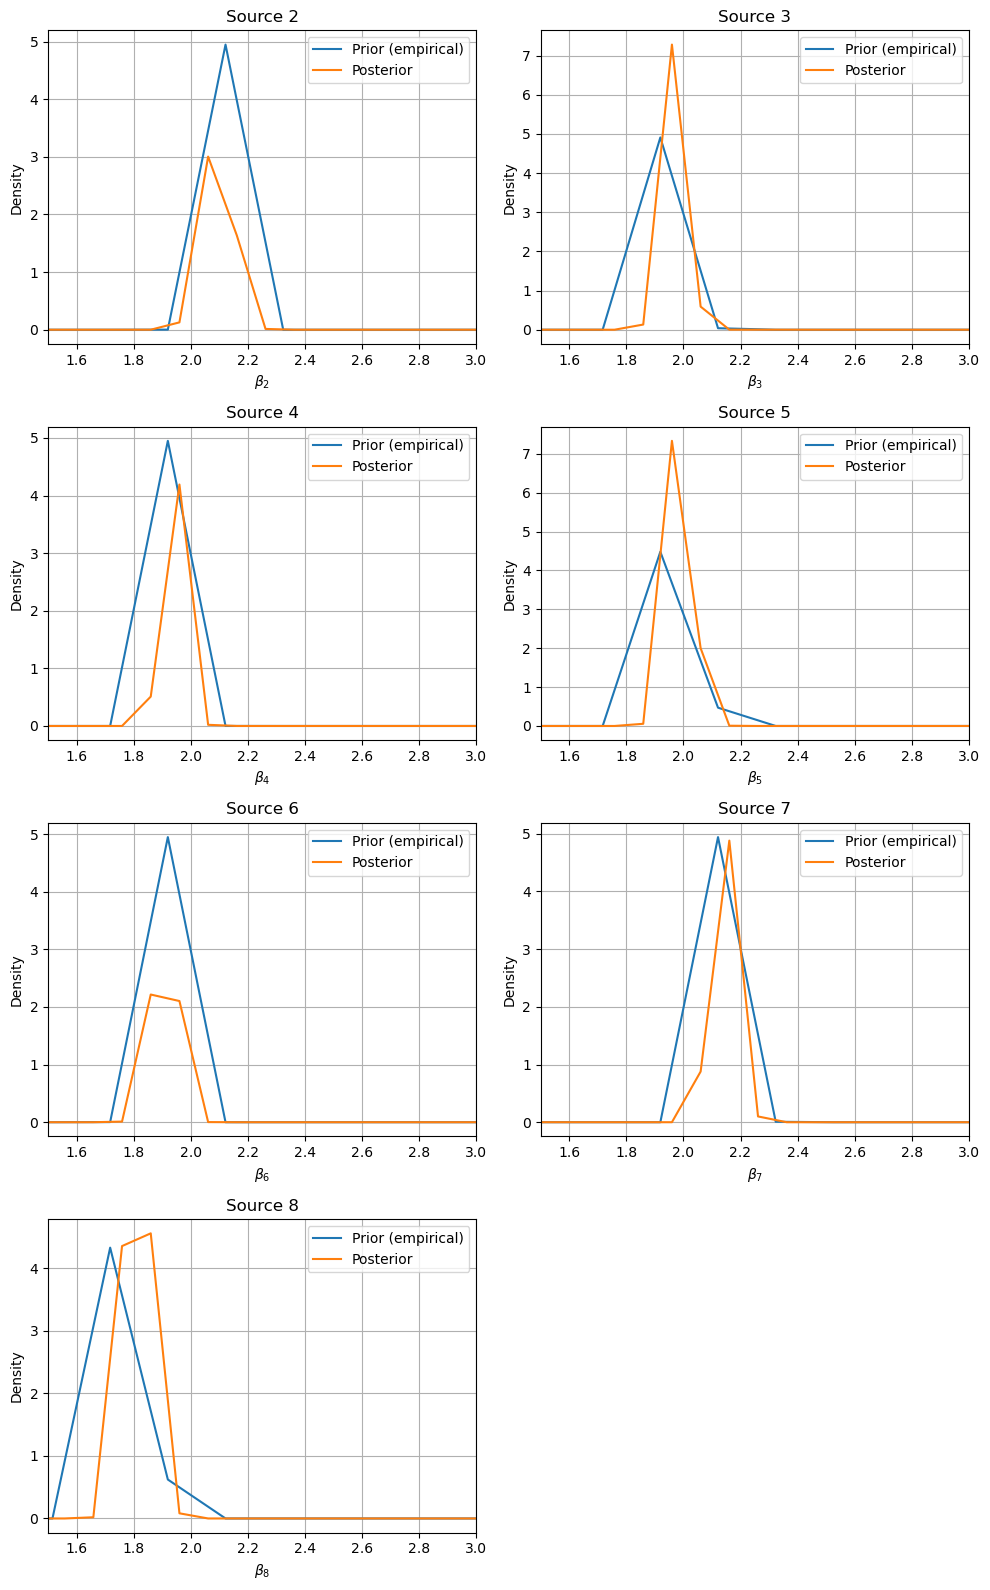

In [63]:
###############################################################################
#  PRIOR–POSTERIOR DENSITY CHECK
#  ---------------------------------------------------------------------------
#  • Uses the profile–likelihood values in `df_sim` as an *empirical prior*
#  • Extracts posterior samples β_s from `idata`
#  • Overlays the two densities for every source that appears in `idata`
###############################################################################

def plot_df_prior_vs_posterior(df_sim, idata):
    """
    Parameters
    ----------
    df_sim : DataFrame
        Columns: ['source','outcome','point','value'] where 'value' is log-likelihood
    idata  : arviz.InferenceData
        From az.from_numpyro(mcmc); must contain `beta_<s>` variables
    """
    # ---- 1) WHICH β_s ARE IN THE POSTERIOR? ----
    beta_vars   = [v for v in idata.posterior.data_vars if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    # ---- 2) PRE-COMPUTE EMPIRICAL PRIOR DENSITIES FROM df_sim ----
    prior_dens  = {}   #   {s: (x_grid, p_density)}
    for s in sources_avl:
        sub = df_sim[df_sim["source"] == s]
        # sum over outcomes at each grid point
        g   = sub.groupby("point")["value"].sum().sort_index()
        x   = g.index.to_numpy()
        ll  = g.values
        ll  = ll - ll.max()              # stabilise exponentiation
        p   = np.exp(ll)
        p   = p / trapezoid(p, x)            # normalise
        prior_dens[s] = (x, p)

    # ---- 3) POSTERIOR KDES ----
    post_beta   = {s: idata.posterior[f"beta_{s}"].values.flatten()
                   for s in sources_avl}
    kde_post    = {s: gaussian_kde(post_beta[s]) for s in sources_avl}



    # ---- 4) PLOT ----
    n = len(sources_avl)
    ncols, nrows = 2, int(np.ceil(n / 2))
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axes = axes.flatten()

    for idx, s in enumerate(sources_avl):
        x_prior, p_prior = prior_dens[s]
        xmin = min(x_prior.min(),  post_beta[s].min())
        xmax = max(x_prior.max(),  post_beta[s].max())
        xgrid = np.linspace(xmin, xmax, 200)

        axes[idx].plot(x_prior, p_prior,              label="Prior (empirical)")
        axes[idx].plot(xgrid, kde_post[s](xgrid),     label="Posterior")
        axes[idx].set_title(f"Source {s}")
        axes[idx].set_xlabel(rf"$\beta_{{{s}}}$")
        axes[idx].set_ylabel("Density")
        axes[idx].legend()
        axes[idx].grid(True)
        axes[idx].set_xlim(1.5, 3)

    for ax in axes[n:]:
        ax.axis("off")

    fig.tight_layout()
    plt.show()
plot_df_prior_vs_posterior(df_sim, idata)

In [15]:
# KL divergence between prior and posterior densities
def kl_prior_posterior_beta(
    df_sim,
    idata,
    *,
    posterior_bins: int | None = None,
    eps: float = 1e-12,
):
    """
    Compute KL( posterior || prior) for each beta_s parameter.

    The prior density is taken from the profile-likelihood table `df_sim`
    (already normalised to integrate to 1).
    The posterior density is estimated with a histogram that uses exactly
    the same support grid, so the numerical integration is straightforward.

    Parameters
    ----------
    df_sim : DataFrame
        Columns: ['source','outcome','point','value'] with log-likelihood
        values per grid point.
    idata : arviz.InferenceData
        Must contain posterior variables  beta_<s>.
    posterior_bins : int, optional
        If given, overrides the grid from `df_sim` and builds an equally
        spaced grid with this many bins.  `None` (default) means: “use the
        grid contained in df_sim”.
    eps : float
        Small positive number added to both densities to avoid log(0).

    Returns
    -------
    kl_dict : dict  {source: KL divergence}
    """
    import re
    import numpy as np
    from scipy.integrate import trapezoid

    # -------- 1) Which β_s parameters are present?
    beta_vars   = [v for v in idata.posterior.data_vars if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    kl_dict = {}

    for s in sources_avl:
        # ---------- prior density on its grid --------------------
        sub = df_sim[df_sim["source"] == s]
        g   = sub.groupby("point")["value"].sum().sort_index()
        x_prior = g.index.to_numpy()
        ll = g.values - g.values.max()
        p_prior = np.exp(ll)
        p_prior = p_prior / trapezoid(p_prior, x_prior)

        # ---------- choose the grid / bin edges ------------------
        if posterior_bins is None:
            # use the df_sim grid
            # build edges so that each bin is centred on a prior grid point
            dx           = np.diff(x_prior)
            left_edges   = x_prior[:-1] - dx / 2.0
            right_edges  = x_prior[:-1] + dx / 2.0
            edges        = np.concatenate(
                ([left_edges[0]], right_edges, [x_prior[-1] + dx[-1] / 2.0])
            )
        else:
            edges = np.linspace(x_prior.min(), x_prior.max(), posterior_bins + 1)

        # ---------- posterior density on the same grid -----------
        samples = idata.posterior[f"beta_{s}"].values.flatten()
        counts, _ = np.histogram(samples, bins=edges, density=True)
        # `counts` is already a density (area = 1); align it with mid-points
        if posterior_bins is None:
            p_post = counts
            dx = np.diff(edges)                # width per bin
        else:
            # re-evaluate prior on the new grid to match dimensions
            mid   = 0.5 * (edges[:-1] + edges[1:])
            from scipy.interpolate import interp1d
            interp = interp1d(x_prior, p_prior, bounds_error=False, fill_value=0.0)
            p_prior = interp(mid)
            p_post  = counts
            dx      = np.diff(edges)

        # ---------- KL divergence (numerical integral) -----------
        # add eps to avoid division by / log of zero
        p_post_safe  = p_post  + eps
        p_prior_safe = p_prior + eps
        kl = np.sum(dx * p_post_safe * np.log(p_post_safe / p_prior_safe))

        kl_dict[s] = kl

    return kl_dict

kl_vals = kl_prior_posterior_beta(df_sim, idata)
for s, kl in kl_vals.items():
    print(f"Source {s}: KL(posterior‖prior) = {kl:0.4f}")


Source 2: KL(posterior‖prior) = 0.0868
Source 3: KL(posterior‖prior) = 0.0613
Source 4: KL(posterior‖prior) = 0.0139
Source 5: KL(posterior‖prior) = 0.0400
Source 6: KL(posterior‖prior) = 0.0104
Source 7: KL(posterior‖prior) = 0.0264
Source 8: KL(posterior‖prior) = 0.4232


In [62]:
def summarise_beta_prior_posterior(
        df_sim,
        idata,
        experiment_label: int = 1
):
    """
    For each beta_s parameter:

        • numerical mean  & median of the PRIOR density
        • mean, median and 0.95 CI of the POSTERIOR draws
        • flag indicating whether the CI contains the prior mean

    Returns
    -------
    stats_df : pandas.DataFrame
        Columns
            source
            prior_mean   prior_median
            post_mean    post_median
            post_ci_lower  post_ci_upper
            ci_covers_prior_mean   (bool)
    """

    # 1 ── locate the beta variables in the posterior
    beta_vars = [v for v in idata.posterior.data_vars if re.fullmatch(r"beta_\d+", v)]

    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    records = []

    # 2 ── loop over sources
    for s in sources_avl:
        # ----- PRIOR density on grid ----------------------------
        sub = df_sim[df_sim["source"] == s]
        g = sub.groupby("point")["value"].sum().sort_index()
        x = g.index.to_numpy()
        ll = g.values - g.values.max()  # stabilise exponentiation
        p = np.exp(ll)
        p = p / trapezoid(p, x)  # normalise

        prior_mean = trapezoid(x * p, x)

        # median: CDF crosses 0.5
        # cumulative integral (trapezoidal)
        cdf = np.concatenate(
            ([0.0],
             np.cumsum((p[:-1] + p[1:]) / 2 * np.diff(x)))
        )
        # interpolate to find the 0.5 point
        median_interp = interp1d(cdf, x, bounds_error=False)
        prior_median = float(median_interp(0.5))

        # ----- POSTERIOR summary --------------------------------
        samples = idata.posterior[f"beta_{s}"].values.flatten()
        post_mean = float(np.mean(samples))
        post_median = float(np.median(samples))
        ci_lower, ci_upper = np.percentile(samples, [2.5, 97.5])

        covers = (ci_lower <= prior_mean) and (prior_mean <= ci_upper)
        mean_error = np.abs(prior_mean - post_mean)
        median_error = np.abs(prior_median - post_median)

        records.append(dict(
            experiment = experiment_label,
            source="beta{}".format(s),
            prior_mean=prior_mean,
            prior_median=prior_median,
            post_mean=post_mean,
            post_median=post_median,
            mean_error=mean_error,
            median_error=median_error,
            post_ci_lower=ci_lower,
            post_ci_upper=ci_upper,
            ci_covers_prior_mean=covers,
        ))

    stats_df = pd.DataFrame.from_records(records)
    return stats_df

stats = summarise_beta_prior_posterior(df_sim, idata,1)
print(stats)

# save to csv
stats.to_csv("beta_prior_posterior_stats.csv", index=False)



   experiment source  prior_mean  prior_median  post_mean  post_median  \
0           1  beta2    2.121154      2.121154   2.105354     2.111936   
1           1  beta3    1.920756      1.920756   1.946680     1.937388   
2           1  beta4    1.919210      1.919210   1.925154     1.922835   
3           1  beta5    1.938376      1.938376   1.973074     1.960832   
4           1  beta6    1.919095      1.919095   1.912022     1.915259   
5           1  beta7    2.121535      2.121535   2.128261     2.124885   
6           1  beta8    1.742566      1.742566   1.818289     1.819739   

   mean_error  median_error  post_ci_lower  post_ci_upper  \
0    0.015801      0.009218       2.021015       2.160551   
1    0.025924      0.016632       1.891881       2.046315   
2    0.005944      0.003626       1.874138       1.983838   
3    0.034698      0.022456       1.903429       2.098862   
4    0.007074      0.003836       1.848759       1.962552   
5    0.006726      0.003349       2.06833

In [61]:
def summarise_beta_prior_posterior_sample(
        df_sim,
        idata,
        experiment: int = 1
):
    """
    For each β_s parameter compute

        • prior sample mean & median (raw `point` column of df_sim)
        • posterior sample mean, median, 95 % CI
        • flag : does the 95 % CI cover the prior sample mean?

    Returns
    -------
    pandas.DataFrame with columns
        source
        prior_mean prior_median
        post_mean post_median
        post_ci_lower post_ci_upper
        ci_covers_prior_mean
    """
    # ── locate β_s in the posterior ───────────────────────────────
    beta_vars = [v for v in idata.posterior.data_vars
                 if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    rows = []

    for s in sources_avl:
        # ── PRIOR sample statistics (raw grid points) -------------
        prior_samples = df_sim.loc[df_sim["source"] == s, "point"].values
        prior_mean = float(np.mean(prior_samples))
        prior_median = float(np.median(prior_samples))

        # ── POSTERIOR sample statistics ---------------------------
        post_samples = idata.posterior[f"beta_{s}"].values.flatten()
        post_mean = float(np.mean(post_samples))
        post_median = float(np.median(post_samples))
        ci_lower, ci_upper = np.percentile(post_samples, [2.5, 97.5])

        covers = (ci_lower <= prior_mean) and (prior_mean <= ci_upper)

        rows.append(dict(
            source=s,
            prior_mean=prior_mean,
            prior_median=prior_median,
            post_mean=post_mean,
            post_median=post_median,
            post_ci_lower=ci_lower,
            post_ci_upper=ci_upper,
            ci_covers_prior_mean=covers,
        ))

    return pd.DataFrame(rows)

stats = summarise_beta_prior_posterior(df_sim, idata, 1)
print(stats)

   experiment source  prior_mean  prior_median  post_mean  post_median  \
0           1  beta2    2.121154      2.121154   2.105354     2.111936   
1           1  beta3    1.920756      1.920756   1.946680     1.937388   
2           1  beta4    1.919210      1.919210   1.925154     1.922835   
3           1  beta5    1.938376      1.938376   1.973074     1.960832   
4           1  beta6    1.919095      1.919095   1.912022     1.915259   
5           1  beta7    2.121535      2.121535   2.128261     2.124885   
6           1  beta8    1.742566      1.742566   1.818289     1.819739   

   mean_error  median_error  post_ci_lower  post_ci_upper  \
0    0.015801      0.009218       2.021015       2.160551   
1    0.025924      0.016632       1.891881       2.046315   
2    0.005944      0.003626       1.874138       1.983838   
3    0.034698      0.022456       1.903429       2.098862   
4    0.007074      0.003836       1.848759       1.962552   
5    0.006726      0.003349       2.06833